# Classifying Images with a NN and DNN Model

## Introduction

In this notebook, you learn how to build a neural network to classify the tf-flowers dataset using a Deep Neural Network Model.

## Learning Objectives

* Define Helper Functions.
* Train and evaluate a Neural Network (NN) model.
* Train and evaluate a Deep Neural Network model.


Each learning objective will correspond to a __#TODO__ in the student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/classifying_images_with_a_nn_and_dnn_model.ipynb).


In [1]:
# Import and print the installed version of TensorFlow
import tensorflow as tf
print(tf.version.VERSION)

2.6.5


In [2]:
conda install graphviz

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.38.0             |       hd4edc92_1         539 KB  conda-forge
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    cairo-1.18.0               |       h3faef2a_0         959 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    conda-24.1.1               |   py39hf3d152e_0         935 KB  conda-forge
    expat-2.5.0                |       hcb278e6_1         134 KB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code-pro-2.038|       h77eed

## Defining Helper Functions
#### Reading and Preprocessing image data

In [3]:
# Helper functions
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    dataset = (tf.data.TextLineDataset(filename).map(decode_csv))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
    # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
    WEIGHT_TYPE = 0 # 0 for weight, 1 for bias
    
    f, ax = plt.subplots(1, 5, figsize=(15,15))
    for flower in range(len(CLASS_NAMES)):
        weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
        min_wt = tf.math.reduce_min(weights).numpy()
        max_wt = tf.math.reduce_max(weights).numpy()
        flower_name = CLASS_NAMES[flower]
        print("Scaling weights for {} in {} to {}".format(flower_name, min_wt, max_wt))
        weights = (weights - min_wt)/(max_wt - min_wt)
        ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
        ax[flower].set_title(flower_name);

In [4]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename) # TODO 1 -- Your code here
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2024-02-22 06:32:04.227256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-02-22 06:32:04.227320: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-22 06:32:04.227358: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240222-115446): /proc/driver/nvidia/version does not exist
2024-02-22 06:32:04.230499: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train and evaluate a Neural Network (NN) model

One way to get a more complex method is to interpose one or more Dense layers in between the input and output. The model now has three layers. A layer with trainable weights such as the one recently added, that is neither the input nor the output, is called a hidden layer.

In Keras, you introduce the activation function with tf.keras.activations.

The Rectified Linear Unit (ReLU) is the most commonly used activation function for hidden layers – other commonly used activation functions include sigmoid, tanh, and elu.

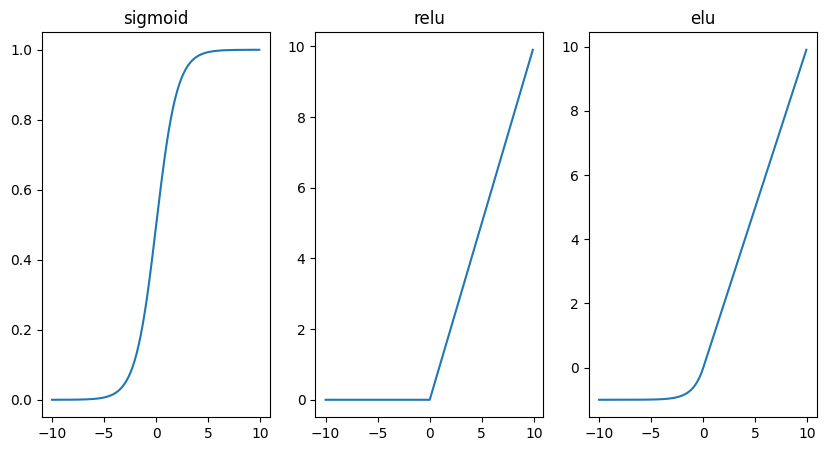

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


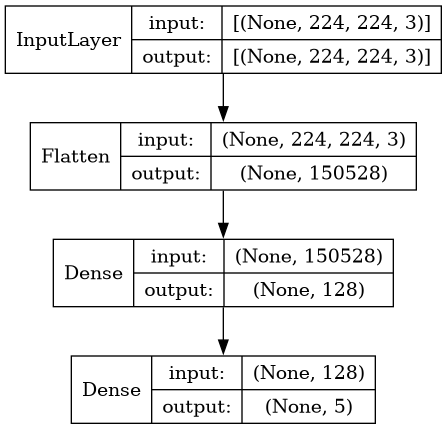

In [6]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [7]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [ ]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset,validation_data=eval_dataset,epochs=10) # TODO 2 -- Your code here

2024-02-22 06:34:21.891215: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
104/104 [==============================] - 83s 794ms/step - loss: 15.7172 - accuracy: 0.3394 - val_loss: 3.3608 - val_accuracy: 0.3351
Epoch 2/10
104/104 [==============================] - 83s 794ms/step - loss: 2.9275 - accuracy: 0.4230 - val_loss: 4.8246 - val_accuracy: 0.3324
Epoch 3/10
104/104 [==============================] - 81s 773ms/step - loss: 2.4471 - accuracy: 0.4630 - val_loss: 2.3424 - val_accuracy: 0.4297
Epoch 4/10
104/104 [==============================] - 99s 953ms/step - loss: 1.7350 - accuracy: 0.5130 - val_loss: 5.0487 - val_accuracy: 0.3270
Epoch 5/10
104/104 [==============================] - 84s 804ms/step - loss: 2.2605 - accuracy: 0.4600 - val_loss: 2.1653 - val_accuracy: 0.3595
Epoch 6/10
104/104 [==============================] - 90s 863ms/step - loss: 1.5281 - accuracy: 0.3955 - val_loss: 1.5274 - val_accuracy: 0.2946
Epoch 7/10
104/104 [==============================] - 96s 922ms/step - loss: 1.3895 - accuracy: 0.4455 - val_loss: 1.5773 - val_a

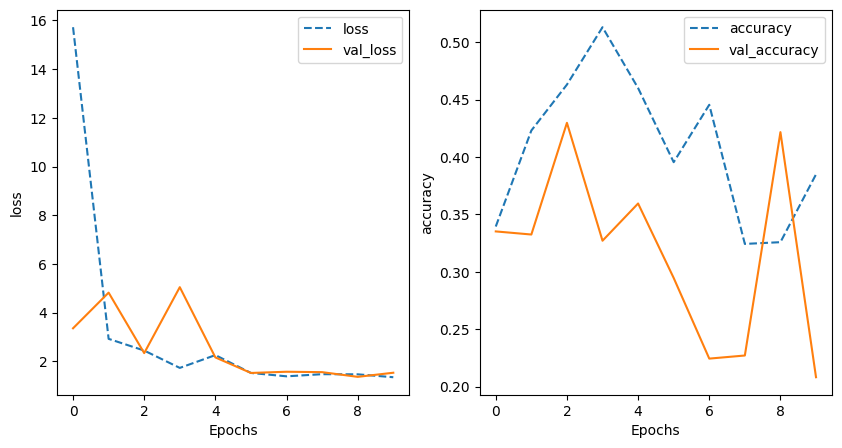

In [ ]:
training_plot(['loss', 'accuracy'], history)

## Training the neural network

Training the neural network is similar to training the linear model. Compile the model passing in the optimizer, the loss, and the metrics. Then, call model.fit() passing in the datasets.

In [10]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = (tf.data.TextLineDataset(
        "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
                     map(decode_csv)).batch(batch_size)
    
    eval_dataset = (tf.data.TextLineDataset(
        "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
                    map(decode_csv)).batch(32) # this doesn't matter
    
    # NN with one hidden layers
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        tf.keras.layers.Dense(num_hidden,kernel_regularizer=regularizer,activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(len(CLASS_NAMES),kernel_regularizer=regularizer,activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    
    return model

First, train your model by using 128 hidden layers.

Epoch 1/10
104/104 [==============================] - 87s 831ms/step - loss: 1.9823 - accuracy: 0.3645 - val_loss: 1.3662 - val_accuracy: 0.4324
Epoch 2/10
104/104 [==============================] - 86s 816ms/step - loss: 1.3447 - accuracy: 0.4339 - val_loss: 1.3846 - val_accuracy: 0.4324
Epoch 3/10
104/104 [==============================] - 86s 829ms/step - loss: 1.2584 - accuracy: 0.4748 - val_loss: 1.3618 - val_accuracy: 0.4324
Epoch 4/10
104/104 [==============================] - 102s 976ms/step - loss: 1.1725 - accuracy: 0.5161 - val_loss: 1.4153 - val_accuracy: 0.4108
Epoch 5/10
104/104 [==============================] - 94s 892ms/step - loss: 1.1419 - accuracy: 0.5342 - val_loss: 1.4302 - val_accuracy: 0.4189
Epoch 6/10
104/104 [==============================] - 84s 802ms/step - loss: 1.1006 - accuracy: 0.5585 - val_loss: 1.3084 - val_accuracy: 0.4541
Epoch 7/10
104/104 [==============================] - 82s 783ms/step - loss: 1.1148 - accuracy: 0.5567 - val_loss: 1.3109 - val_a

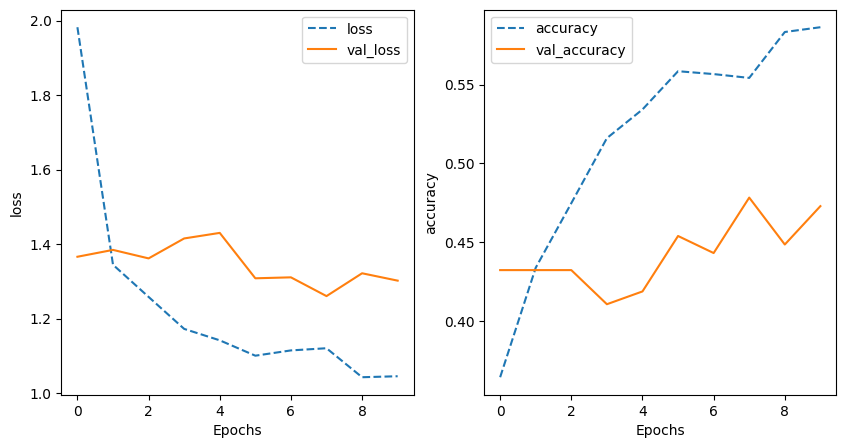

In [11]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

You would normally expect that adding layers to a model will improve the ability of the model to fit the training data, and thus lower the loss. Notice that it is not always the case though.

Epoch 1/10
104/104 [==============================] - 110s 1s/step - loss: 2.5407 - accuracy: 0.3548 - val_loss: 1.8374 - val_accuracy: 0.3514
Epoch 2/10
104/104 [==============================] - 88s 828ms/step - loss: 1.5416 - accuracy: 0.4255 - val_loss: 1.7378 - val_accuracy: 0.4027
Epoch 3/10
104/104 [==============================] - 88s 842ms/step - loss: 1.4326 - accuracy: 0.4661 - val_loss: 1.4296 - val_accuracy: 0.4541
Epoch 4/10
104/104 [==============================] - 86s 826ms/step - loss: 1.3332 - accuracy: 0.5003 - val_loss: 1.3076 - val_accuracy: 0.4865
Epoch 5/10
104/104 [==============================] - 86s 824ms/step - loss: 1.3042 - accuracy: 0.5194 - val_loss: 1.4376 - val_accuracy: 0.4541
Epoch 6/10
104/104 [==============================] - 108s 1s/step - loss: 1.2746 - accuracy: 0.5358 - val_loss: 1.6180 - val_accuracy: 0.4568
Epoch 7/10
104/104 [==============================] - 84s 806ms/step - loss: 1.3174 - accuracy: 0.5306 - val_loss: 1.6575 - val_accura

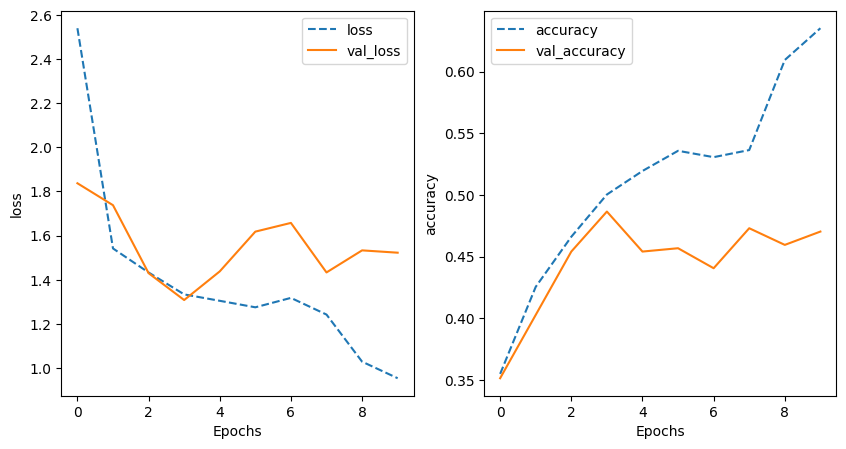

In [12]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

## Train and evaluate a Deep Neural Network model

Now train a DNN. You need to parameterize the number of layers, and the number of nodes in each layer.

In [13]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
    
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
                     map(decode_csv)).batch(batch_size)
    
    eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
                    map(decode_csv)).batch(32) # this doesn't matter
    
    # NN with multiple hidden layers
    layers = [tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),name='input_pixels')]
    
    layers = layers + [
        tf.keras.layers.Dense(nodes,kernel_regularizer=regularizer,activation=tf.keras.activations.relu,
                              name='hidden_dense_{}'.format(hno)) for hno, nodes in enumerate(num_hidden)
    ]
    layers = layers + [
        tf.keras.layers.Dense(len(CLASS_NAMES),kernel_regularizer=regularizer,activation='softmax',name='flower_prob')
    ]
    
    model = tf.keras.Sequential(layers, name='flower_classification')
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
    
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 128)               19267712  
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                2064      
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 19,269,861
Trainable params: 19,269,861
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 93s 884ms/step - loss: 21.0251 - accuracy: 0.2433 - val_loss: 3.3185 - val_accuracy: 0.2568
Epoch 2/10
104/104 [==============================] - 90s 864ms/step - loss: 3.5

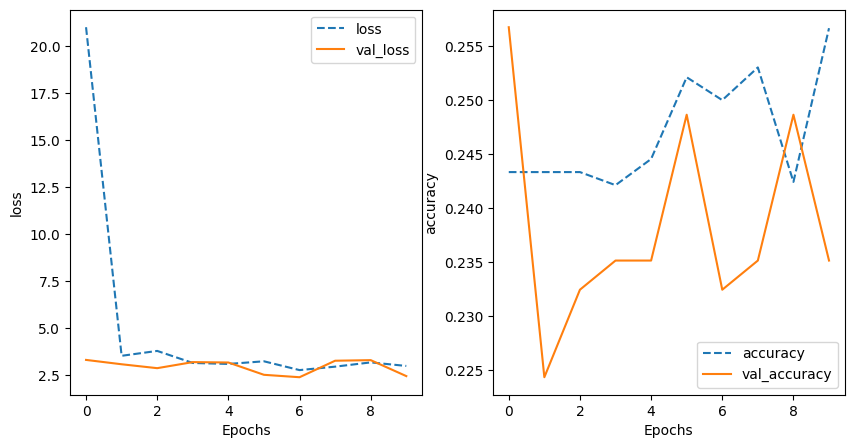

In [14]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0.001, l2=0.001, num_hidden=[128,16]) # TODO 3 -- Your code here

Congrats! You've completed the lab!